In [1]:
# Useful starting lines
%matplotlib inline
from scipy.sparse import *
import numpy as np
import pickle
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import csv
import seaborn as sns
%load_ext autoreload
%autoreload 2

# Data input and output paths
POS_TRAIN_PATH = 'data/twitter-datasets/train_pos_full.txt' 
NEG_TRAIN_PATH = 'data/twitter-datasets/train_neg_full.txt' 
DATA_TEST_PATH = 'data/twitter-datasets/test_data.txt'
OUTPUT_PATH = 'predictions_out.csv'

# For debugging purpose
np.set_printoptions(threshold= 50)
np.random.seed(10)

## Load the training data into feature matrix, class labels, and event ids:

In [7]:
#''' DON'T RUN, YOU FOOL
!sh ./scripts/build_vocab.sh
!sh ./scripts/cut_vocab.sh
!python3 src/pickle_vocab.py
!python3 src/cooc.py
#'''

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

## Analyse Data


### Null values

In [81]:
pos_ids, pos_text_train = load_csv_test_data(POS_TRAIN_PATH)
neg_ids, neg_text_train = load_csv_test_data(NEG_TRAIN_PATH)

print(len(pos_ids))
pos_train_df = pd.DataFrame({'Label' : np.concatenate([np.array([-1 for _ in range(len(neg_text_train))]), np.ones(len(pos_text_train))]),
                            'Text' : np.concatenate([neg_text_train, pos_text_train])})

1250000


## Comparison of the Tweet length w.r.t. label

In [68]:
pos_train_df.head()

pos_length_train = pos_train_df['Text'][pos_train_df['Label'] == 1.0].str.len()
neg_length_train = pos_train_df['Text'][pos_train_df['Label'] == -1.0].str.len()

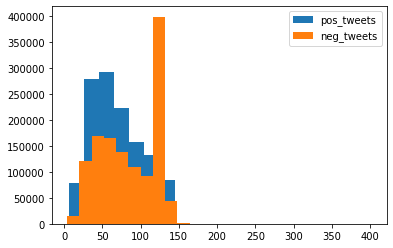

In [39]:
plt.hist(pos_length_train, bins=20, label="pos_tweets")
plt.hist(neg_length_train, bins=20, label="neg_tweets")
plt.legend()
plt.show()

### Clean the tweets

In [5]:
import re # for regular expressions
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [82]:
pos_train_df['clean_text'] = np.vectorize(remove_pattern)(pos_train_df['Text'], "<[\w]*>") 

pos_train_df['clean_text'] = pos_train_df['clean_text'].str.replace("[^a-zA-Z#]", " ")

pos_train_df['clean_text'] = pos_train_df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

pos_train_df.head()


,Label,Text,clean_text
0,-1.0,vinco tresorpack 6 ( difficulty 10 of 10 objec...,vinco tresorpack difficulty object disassemble...
1,-1.0,glad i dot have taks tomorrow ! ! #thankful #s...,glad have taks tomorrow #thankful #startho
2,-1.0,1-3 vs celtics in the regular season = were fu...,celtics regular season were fucked play them p...
3,-1.0,<user> i could actually kill that girl i'm so ...,could actually kill that girl sorry
4,-1.0,<user> <user> <user> i find that very hard to ...,find that very hard believe afraid


## Word Occurences w.r.t. label

In [83]:
tokenized_tweet = pos_train_df['clean_text'].apply(lambda x: x.split()) # tokenizing

from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [84]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

    
pos_train_df['clean_text']= tokenized_tweet

export_csv = pos_train_df.to_csv (r'data/twitter-datasets/train_pos_clean.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

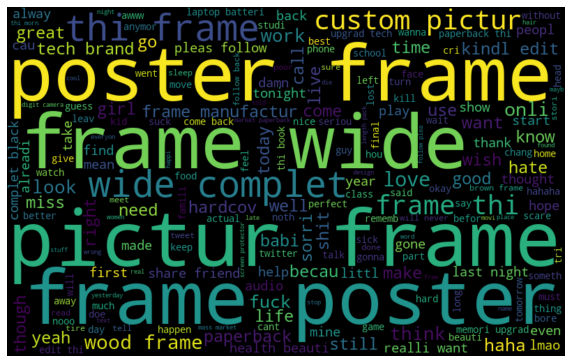

In [44]:
all_neg_words = ' '.join([text for text in pos_train_df['clean_text'][pos_train_df['Label'] == -1.0]])
all_pos_words = ' '.join([text for text in pos_train_df['clean_text'][pos_train_df['Label'] == 1.0]])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_neg_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

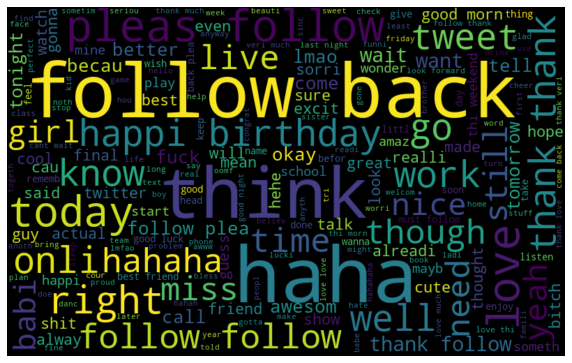

In [45]:
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_pos_words)

plt.figure(figsize=(10, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [50]:
export_csv = pos_train_df['clean_text'].to_csv (r'data/twitter-datasets/train_pos_clean.csv', index = None, header=False) #Don't forget to add '.csv' at the end of the path

### Hashtag tudy


In [51]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [ ]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(pos_train_df['clean_text'][pos_train_df['Label'] == 1])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(pos_train_df['clean_text'][pos_train_df['Label'] == -1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])



In [ ]:
import nltk # for text manipulation

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
print(d)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()



In [ ]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 20 most frequent hashtags
e = e.nlargest(columns="Count", n = 20) 
print(e)

plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")

In [11]:
#''' DON'T RUN, YOU FOOL
print("loading cooccurrence matrix")
#with open('cooc.pkl', 'rb') as f:
with open('cooc.pkl', 'rb') as f:
    cooc = pickle.load(f)
print("{} nonzero entries".format(cooc.nnz))

nmax = 100
print("using nmax =", nmax, ", cooc.max() =", cooc.max())

print("initializing embeddings")
embedding_dim = 20
xs = np.random.normal(size=(cooc.shape[0], embedding_dim))
ys = np.random.normal(size=(cooc.shape[1], embedding_dim))
#'''

loading cooccurrence matrix
20201527 nonzero entries
using nmax = 100 , cooc.max() = 403956
initializing embeddings


In [12]:
#''' DON'T RUN, YOU FOOL
eta = 0.001
alpha = 3 / 4

epochs = 10

for epoch in range(epochs):
    print("epoch {}".format(epoch))
    for ix, jy, n in zip(cooc.row, cooc.col, cooc.data):
        logn = np.log(n)
        fn = min(1.0, (n / nmax) ** alpha)
        x, y = xs[ix, :], ys[jy, :]
        scale = 2 * eta * fn * (logn - np.dot(x, y))
        xs[ix, :] += scale * y
        ys[jy, :] += scale * x
        
np.save('embeddings', xs)
#'''

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


### Prepare the Data

In [ ]:
embeddings = np.load('saved_gen_files/embeddings.npy')

train_text_neg = open(NEG_TRAIN_PATH, 'r').readlines()
train_text_pos = open(POS_TRAIN_PATH, 'r').readlines()
# Construct the two arrays 
train_text = np.array(train_text_neg + train_text_pos)
train_y = np.concatenate([np.array([-1 for _ in range(len(train_text_neg))]), np.ones(len(train_text_pos))])

In [85]:
with open('vocab.pkl', 'rb') as f:
    voc = pickle.load(f)

def toAvgVec(t):
    
    _, K = xs.shape
    sum_vec = np.zeros((K))
   # words = t.split()
  #  print(t)
    if(pd.isnull(t)):
        print(t)
    for word in t:
        index = voc.get(word)
   #     print(index)
        if index is not None:
            sum_vec += xs[index]
            #print(sum_vec)
            
    return sum_vec/len(t)
# Create numerical feature matrix of tweets
#pos_train_df = pd.read_csv('data/twitter-datasets/train_pos_clean.csv')
print(pos_train_df)
#train_data = np.zeros(len(pos_train_df['clean_text'])*xs.shape[1]).reshape(len(pos_train_df['clean_text']), 20)
#pos_train_df = pos_train_df.sample(frac=1).reset_index(drop=False)
for i in range(len(pos_train_df)):
    train_data[i] = toAvgVec(pos_train_df['clean_text'].at[i])
    
#np.save('saved_gen_files/embedded_data2', train_data)


         Label                                               Text  \
0         -1.0  vinco tresorpack 6 ( difficulty 10 of 10 objec...   
1         -1.0  glad i dot have taks tomorrow ! ! #thankful #s...   
2         -1.0  1-3 vs celtics in the regular season = were fu...   
3         -1.0  <user> i could actually kill that girl i'm so ...   
4         -1.0  <user> <user> <user> i find that very hard to ...   
...        ...                                                ...   
2499995    1.0  a warning sign ? (; rt <user> the negativity y...   
2499996    1.0                    <user> ff too thank youuu ) )\n   
2499997    1.0              i just love shumpa ! that's my girl\n   
2499998    1.0  the best way to start a day ! no matter what h...   
2499999    1.0  #frenchieswant1dtou i'm not from french but <u...   

                                                clean_text  
0        vinco tresorpack difficulti object disassembl ...  
1                   glad have tak tomorrow #thank

/home/arthy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, pos_train_df['Label'])

In [87]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [3]:
def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})
            
def load_csv_test_data(data_path, sub_sample=False, has_ID=False):

    raw = open(data_path, 'r').readlines()
    ids = np.zeros(len(raw))
    data = np.array(["" for _ in range(len(raw))], dtype='object')
    i = 0
    if has_ID:
        for line in raw:
            idd, dat = line.split(",", 1)
            ids[i] = int(idd)
            data[i] += dat
            i = i + 1
    else:
        for line in raw:
            data[i] += line
            i = i + 1


    return ids, data

### Outliers 

In [ ]:
# Create numerical feature matrix of tweets
ids, text_test = load_csv_test_data(DATA_TEST_PATH)
X_test = np.zeros(len(text_test)*embeddings.shape[1]).reshape(len(text_test), 20)

clf.fit(train_data, train_y)

for i in range(len(text_test)):
    X_test[i] = toAvgVec(text_test[i])
    
create_csv_submission(ids, clf.predict(X_test), OUTPUT_PATH)

